In [1]:
%pylab inline
import warnings
import numpy as np
from tqdm import trange
from mnist_util import fetch#, plot, imshow
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


3


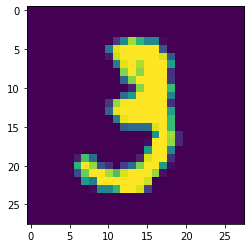

In [2]:
# data starts at offset 16
x_train_url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
x_test_url = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'

# data starts at index 8
y_train_url = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
y_test_url = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'

# download datasets
x_train = fetch(x_train_url)[16:].reshape(-1, 28*28)
y_train = fetch(y_train_url)[8:]

x_test = fetch(x_test_url)[16:].reshape(-1, 28*28)
y_test = fetch(y_test_url)[8:]

# display
i = 10
img = x_train[i]
print(y_train[i])
imshow(img.reshape(28, 28))

In [3]:
np.random.seed(1337)

# quadratic cost function
def cost(a, y):
    return np.square(y - a).mean(dtype=np.float32)

# derivative of cost function with respect to y_pred
def d_cost(a, y):
    return (a - y)

def get_batch(size):
    mask = np.random.randint(0, x_train.shape[0], size=(size))
    xx, yy = x_train[mask], y_train[mask]
    out = np.zeros((len(yy), 10))
    out[range(yy.shape[0]), yy] = 1
    yy = out
    return xx, yy

def evaluate():
    _, _, _, y_preds = forward(x_test)
    y_preds = np.argmax(y_preds, axis=1)
    return (y_preds == y_test).mean()

def init_weights(x, y):
    return np.random.uniform(-1., 1., size=(x, y)) / np.sqrt(x * y)

In [4]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [5]:
layers = (784, 128, 10)
weights = [init_weights(x, y) for x, y in zip(layers[:-1], layers[1:])]
for w in weights:
    print(w.shape)

(784, 128)
(128, 10)


In [6]:
def forward(x):
    z1 = x.dot(weights[0])
    a1 = sigmoid(z1)
    z2 = a1.dot(weights[1])
    a2 = sigmoid(z2)
    return z1, a1, z2, a2

In [7]:
def backward(z1, a1, z2, a2):
    e2 = d_cost(a2, y) * sigmoid_prime(z2)    
    e1 = e2.dot(weights[1].T) * sigmoid_prime(z1)
    w2_adj = a1.T.dot(e2)
    w1_adj = x.T.dot(e1)
    return w1_adj, w2_adj

In [8]:
# hyperparameters
epochs = 1200
lr = 0.001
batch_size = 128
losses, accuracies = [], []

# train
for i in (t := trange(epochs)):
    # batch
    x, y = get_batch(batch_size)
    
    # forward pass
    z1, a1, z2, a2 = forward(x)
    
    # calculate loss
    loss = cost(a2, y)
    
    # backwards pass
    w1_adj, w2_adj = backward(z1, a1, z2, a2)
    
    # predict, calculate accuracy
    predictions, actual = np.argmax(a2, axis=1), np.argmax(y, axis=1)
    accuracy = np.equal(predictions, actual).mean()
    
    # track loss/accuracy over time
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    
    # gradient descent
    weights[0] = weights[0] - lr * w1_adj
    weights[1] = weights[1] - lr * w2_adj

loss 0.03 accuracy 0.88: 100%|██████████| 1200/1200 [00:03<00:00, 326.69it/s]


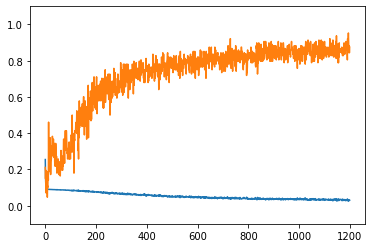

In [9]:
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [10]:
evaluate()

0.8695

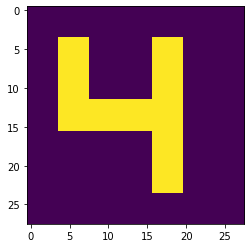

In [11]:
m = [[0,0,0,0,0,0,0],
     [0,1,0,0,1,0,0],
     [0,1,0,0,1,0,0],
     [0,1,1,1,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
# upscale to 28x28
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
imshow(m.reshape(28,28))

In [12]:
_, _, _, x = forward(m)
print(np.argmax(x))

4
